In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models

In [3]:
data_dir = 'seg_dataset'

image_path = []
labels = []

for label in os.listdir(data_dir):
    for img_file in os.listdir(os.path.join(data_dir,label)):
        image_path.append(os.path.join(data_dir,label,img_file))
        labels.append(label)

data = pd.DataFrame({
    'image_path' : image_path,
    'label': labels
})

In [4]:
data

,image_path,label
0,seg_dataset\cataract\0_left.jpg,cataract
1,seg_dataset\cataract\103_left.jpg,cataract
2,seg_dataset\cataract\1062_right.jpg,cataract
3,seg_dataset\cataract\1083_left.jpg,cataract
4,seg_dataset\cataract\1084_right.jpg,cataract
...,...,...
4212,seg_dataset\normal\8_right.jpg,normal
4213,seg_dataset\normal\939_left.jpg,normal
4214,seg_dataset\normal\939_right.jpg,normal
4215,seg_dataset\normal\951_left.jpg,normal


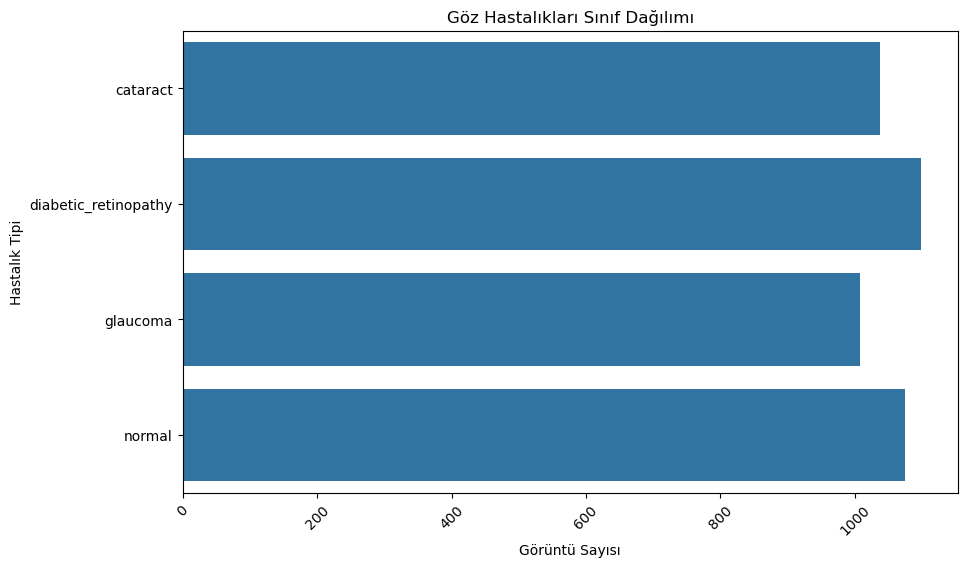

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data['label'])
plt.title('Göz Hastalıkları Sınıf Dağılımı')
plt.xlabel('Görüntü Sayısı')
plt.ylabel('Hastalık Tipi')
plt.xticks(rotation=45)
plt.show()

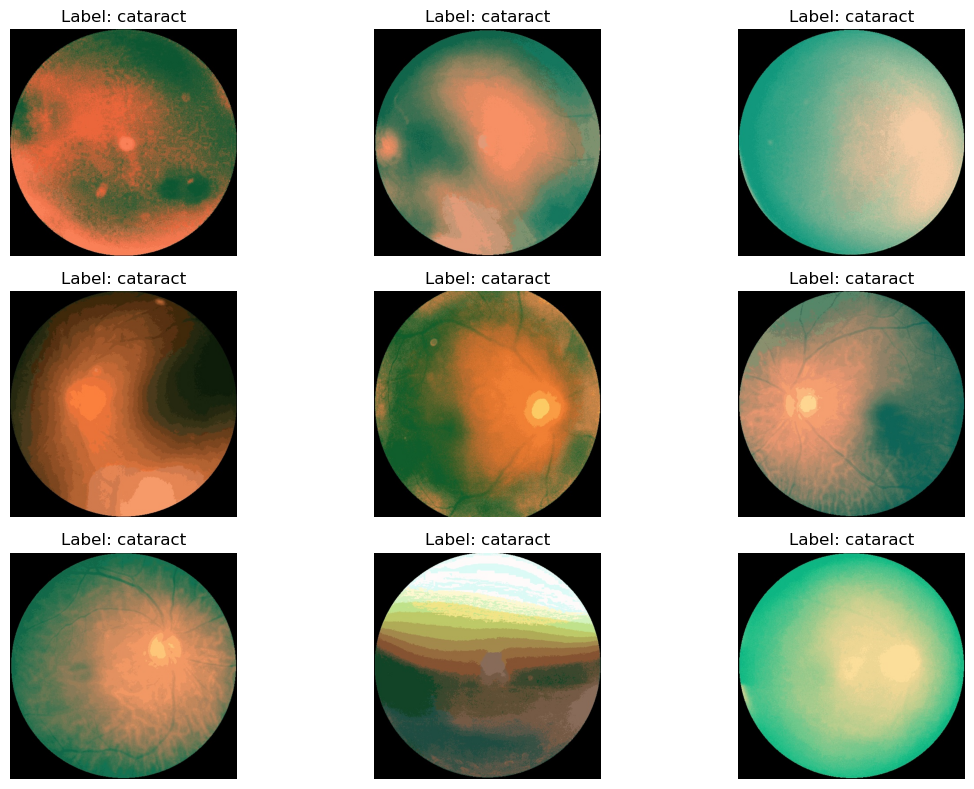

In [6]:
def resim_cizme(image_path, labels, num_samples=9):
    plt.figure(figsize=(12,8))
    for i in range(num_samples):
        img = cv2.imread(image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

resim_cizme(image_path, labels, num_samples=9)

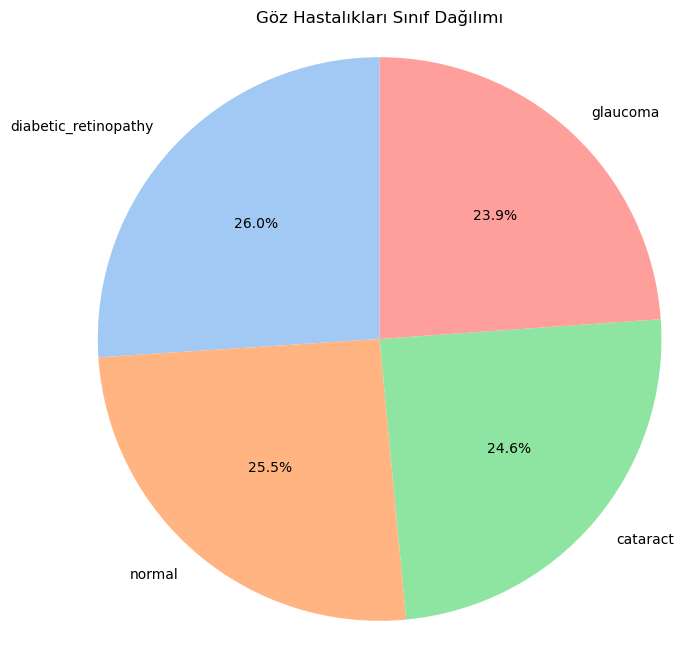

In [7]:
def pasta_grafik(labels):
    plt.figure(figsize=(8,8))
    label_counts= pd.Series(labels).value_counts()

    # pasta grafk çizimi
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Göz Hastalıkları Sınıf Dağılımı')
    plt.axis('equal') # dairesellik için
    plt.show()

pasta_grafik(labels)


In [8]:
IMG_SIZE = 224

def resim_boyutladirma(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 225.0
    return img

X = np.array([resim_boyutladirma(path) for path in data['image_path']])
y = pd.get_dummies(data['label']).values

In [9]:
y

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True]])

In [10]:
new_y = y.astype(int)

In [11]:
new_y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [12]:
label_dataframe = pd.DataFrame(new_y, columns=['cataract','diabetic retinopathy','glaucoma','normal'])
label_dataframe

,cataract,diabetic retinopathy,glaucoma,normal
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
4212,0,0,0,1
4213,0,0,0,1
4214,0,0,0,1
4215,0,0,0,1


In [13]:
concat_data = pd.concat([data['image_path'],label_dataframe], axis=1)

In [14]:
concat_data

,image_path,cataract,diabetic retinopathy,glaucoma,normal
0,seg_dataset\cataract\0_left.jpg,1,0,0,0
1,seg_dataset\cataract\103_left.jpg,1,0,0,0
2,seg_dataset\cataract\1062_right.jpg,1,0,0,0
3,seg_dataset\cataract\1083_left.jpg,1,0,0,0
4,seg_dataset\cataract\1084_right.jpg,1,0,0,0
...,...,...,...,...,...
4212,seg_dataset\normal\8_right.jpg,0,0,0,1
4213,seg_dataset\normal\939_left.jpg,0,0,0,1
4214,seg_dataset\normal\939_right.jpg,0,0,0,1
4215,seg_dataset\normal\951_left.jpg,0,0,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size= 0.3, random_state=42)

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(y_train[0]), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=16, validation_data=(X_test, y_test))

c:\Users\omerf\anaconda3\envs\tensoeflow2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 48s 489ms/step - accuracy: 0.4383 - loss: 1.1902 - val_accuracy: 0.6114 - val_loss: 0.8388
Epoch 2/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.6709 - loss: 0.7322 - val_accuracy: 0.7109 - val_loss: 0.6622
Epoch 3/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.7341 - loss: 0.6319 - val_accuracy: 0.6706 - val_loss: 0.6921
Epoch 4/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.7471 - loss: 0.5959 - val_accuracy: 0.7401 - val_loss: 0.5973
Epoch 5/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 437ms/step - accuracy: 0.7684 - loss: 0.5423 - val_accuracy: 0.7306 - val_loss: 0.6808
Epoch 6/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 426ms/step - accuracy: 0.7748 - loss: 0.5209 - val_accuracy: 0.7425 - val_loss: 0.5993
Epoch 7/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 403ms/step - accuracy: 0.8174 - loss: 0.4249 - val_accuracy: 0.7970 - val_loss: 0.5403
Epoch 8/16
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.8252 - loss: 0.4191 - val_accu

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'test doğruluk oranı : {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8011 - loss: 0.8842
test doğruluk oranı : 0.8159557580947876


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


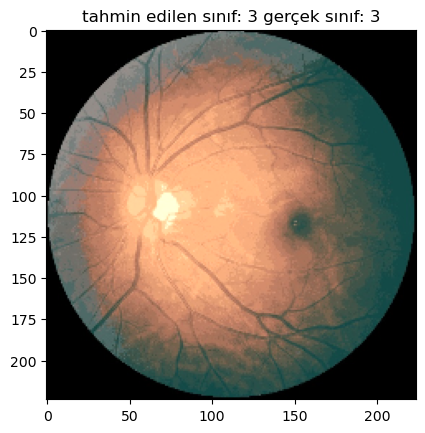

tahmin edilen sınıf: 3
gerçek sınıf: 3


In [18]:
test_img = X_test[300]
true_label = np.argmax(y_test[300])

predict = model.predict(np.expand_dims(test_img, axis=0))
predict_class = np.argmax(predict[0])

plt.imshow(test_img)
plt.title(f'tahmin edilen sınıf: {predict_class} gerçek sınıf: {true_label}')
plt.show()



print(f'tahmin edilen sınıf: {predict_class}')
print(f'gerçek sınıf: {true_label}')